In [14]:
# Load some basic libraries
%matplotlib inline
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.datasets import make_moons, fetch_openml
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay  # Does not work on Google Collab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
Gaia.login(user="avillare", password="Keepcalm81!")

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [3]:
def query_gaia_galaxies():
    query = """
    SELECT TOP 100000
        source_id, random_index, ra, dec, parallax, pm, b,
        SQRT(astrometric_chi2_al / (astrometric_n_good_obs_al - 5)) AS uwe,
        phot_g_mean_mag, bp_g, g_rp, 
        SQRT(phot_g_n_obs/phot_g_mean_flux_over_error) AS relvarg,
        p.classprob_dsc_allosmod_galaxy AS galaxy,
        p.classprob_dsc_allosmod_star AS star
    FROM gaiadr3.gaia_source
    LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
    WHERE p.classprob_dsc_allosmod_galaxy > 0.99
      AND phot_g_mean_mag IS NOT NULL
      AND phot_bp_mean_mag IS NOT NULL
      AND phot_rp_mean_mag IS NOT NULL
      AND parallax IS NOT NULL
      AND pm IS NOT NULL
    ORDER BY random_index
      
    """
    job = Gaia.launch_job_async(query)
    return job.get_results()
  
  
def query_gaia_stars():
    query = """
    SELECT TOP 100000
        source_id, random_index, ra, dec, parallax, pm, b,
        SQRT(astrometric_chi2_al / (astrometric_n_good_obs_al - 5)) AS uwe,
        phot_g_mean_mag, bp_g, g_rp, 
        SQRT(phot_g_n_obs/phot_g_mean_flux_over_error) AS relvarg,
        p.classprob_dsc_allosmod_galaxy AS galaxy,
        p.classprob_dsc_allosmod_star AS star
    FROM gaiadr3.gaia_source
    LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
    WHERE p.classprob_dsc_allosmod_star > 0.99
      AND phot_g_mean_mag IS NOT NULL
      AND phot_bp_mean_mag IS NOT NULL
      AND phot_rp_mean_mag IS NOT NULL
      AND parallax IS NOT NULL
      AND pm IS NOT NULL
    ORDER BY random_index
    """
    job = Gaia.launch_job_async(query)
    return job.get_results()
  
  
def query_gaia_all():
    query = """
    SELECT TOP 100000
        source_id, random_index, ra, dec, parallax, pm, b,
        SQRT(astrometric_chi2_al / (astrometric_n_good_obs_al - 5)) AS uwe,
        phot_g_mean_mag, bp_g, g_rp, 
        SQRT(phot_g_n_obs/phot_g_mean_flux_over_error) AS relvarg,
        p.classprob_dsc_allosmod_galaxy AS galaxy,
        p.classprob_dsc_allosmod_star AS star
    FROM gaiadr3.gaia_source
    LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
    WHERE phot_g_mean_mag IS NOT NULL
      AND phot_bp_mean_mag IS NOT NULL
      AND phot_rp_mean_mag IS NOT NULL
      AND parallax IS NOT NULL
      AND pm IS NOT NULL
    ORDER BY random_index
      
    """
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [ ]:
#table_galaxies = query_gaia_galaxies()
#table_stars = query_gaia_stars()
#table_all = query_gaia_all()

INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
#galaxies = table_galaxies.to_pandas()
#stars = table_stars.to_pandas()
#alls = table_all.to_pandas()

#galaxies['sinb']  = np.sin(galaxies['b']* np.pi/180)
#stars['sinb']  = np.sin(stars['b']* np.pi/180)
#alls['sinb']  = np.sin(alls['b']* np.pi/180)

#galaxies.to_csv("galaxies.csv", index=False)
#stars.to_csv("stars.csv", index=False)
#alls.to_csv("all_objects.csv", index=False)

In [4]:
galaxies = pd.read_csv("galaxies.csv")
stars = pd.read_csv("stars.csv")
alls = pd.read_csv("all_objects.csv")

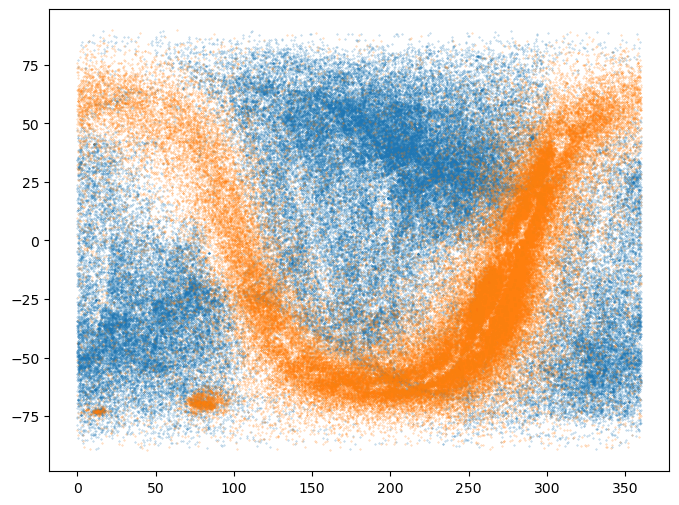

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(galaxies["ra"],galaxies["dec"],s=0.1,alpha = 0.5)
plt.scatter(stars["ra"],stars["dec"],s=0.1,alpha = 0.5)

In [6]:
table_combined = pd.concat([stars,galaxies],ignore_index = True)

In [7]:
table_combined["classification"] = table_combined[["galaxy", "star"]].idxmax(axis=1)
table_combined["classification"] = table_combined["classification"].map({"galaxy": 0, "star": 1})  ## 0 = galaxy, 1 = star

In [8]:
table_combined

,source_id,random_index,ra,dec,parallax,pm,b,uwe,phot_g_mean_mag,bp_g,g_rp,relvarg,galaxy,star,sinb,classification
0,4267180339403392768,0,286.716913,0.276195,1.084924,4.807036,-3.306332,1.047432,15.244129,0.697942,0.824186,0.287703,3.325311e-14,1.000000e+00,-0.057674,1
1,5252403815119316480,1,152.625068,-64.267699,0.854356,5.126574,-6.648696,0.916613,20.906347,0.171606,0.530489,1.107844,1.492212e-08,9.999968e-01,-0.115781,1
2,1937745177867542656,2,348.434982,43.940704,1.042008,3.773118,-15.490523,1.075526,20.531225,0.540527,1.108757,1.573718,2.235166e-09,9.999999e-01,-0.267079,1
3,5971301282285218048,3,252.729717,-37.917215,0.587660,5.458426,4.141483,1.112896,20.145899,1.036097,0.970676,1.183378,8.863590e-11,1.000000e+00,0.072220,1
4,5953201637243132416,4,260.678787,-44.788772,-0.293376,3.440261,-4.748318,1.296979,19.787357,0.317444,1.255966,1.307469,4.441385e-08,9.999999e-01,-0.082779,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1137087270153095680,593185786,114.735613,77.834626,-0.755229,0.936698,28.969322,1.886606,19.882114,-1.032038,2.611912,1.868469,9.999778e-01,3.659922e-06,0.484341,0
199996,4729819166919831552,593194674,55.210598,-56.701045,-0.899555,4.118157,-47.920608,1.715970,20.514019,-1.535990,2.872885,1.853198,9.982729e-01,1.726393e-03,-0.742217,0
199997,6065438993930112640,593201291,204.698666,-54.552389,1.857376,5.069372,7.684063,1.205505,19.958572,-3.634241,5.475812,2.483078,9.999999e-01,3.552539e-08,0.133711,0
199998,1347804516088032128,593208337,259.667672,41.184623,-0.141953,0.228641,34.335164,2.171556,19.170767,-1.859659,3.255920,1.648930,1.000000e+00,1.442504e-08,0.564033,0


In [9]:
features = ["parallax", "sinb","pm", "uwe", "phot_g_mean_mag", "bp_g", "g_rp", "relvarg"]
X = table_combined[features]
y = table_combined["classification"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Adaptive Boosting

In [15]:
params = {
    "n_estimators": [50, 100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]
}


search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    n_iter=20,  
    scoring='accuracy',  
    cv=5,  
    random_state=42,
    verbose=1,
    n_jobs=-1 )

search.fit(X_train, y_train)


print("Best hyperparameters:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 500, 'learning_rate': 0.8}


In [16]:
clf = AdaBoostClassifier(n_estimators=500, learning_rate=0.8, random_state=42)
clf.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=500, random_state=42)

In [17]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["galaxy", "star"]))

print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00     50143
        star       1.00      1.00      1.00     49857

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

[[50102    41]
 [   53 49804]]


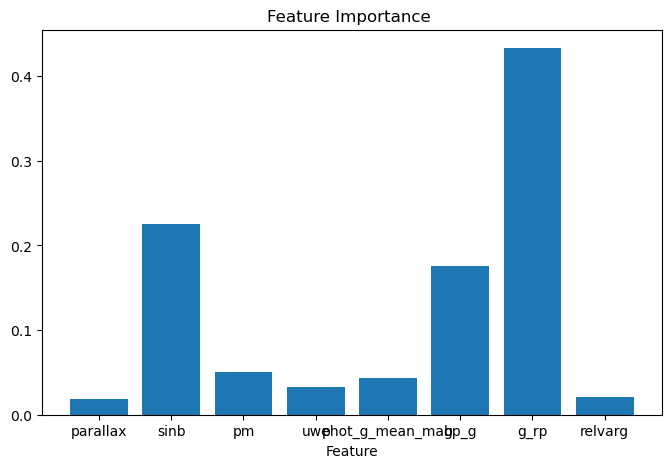

In [18]:
importances = clf.feature_importances_
plt.figure(figsize=(8, 5))
plt.bar(features, importances)
plt.xlabel("Feature")
plt.title("Feature Importance ")
plt.show()